# MiniProject1: Energy consumption prediction for Ro-Ro vessels from sensor data

# **Instructions for the Reviewer**



*   Before running the Colab Notebook, **upload the raw_data.tar file to the file upload area**. This could take 30 minutes atleast, depending on the internet connection. Although the file appears on left pane, please check the bottom of the left pane to track the progress of the file upload.
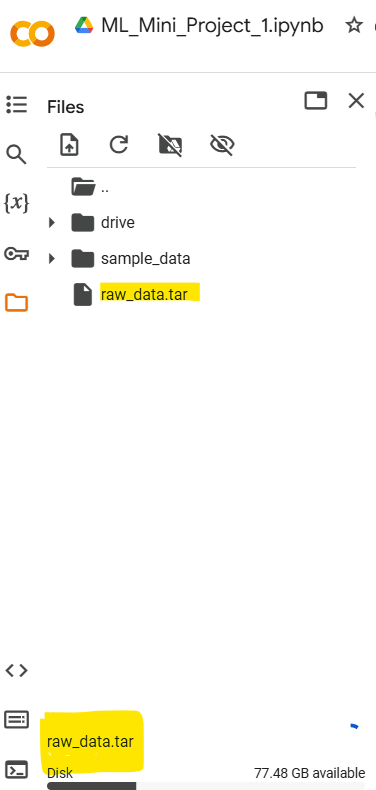

*   The graph visualizations could also take a considerable amount of time.

*   In the last step, I have added code to perform a **GridSearchCV** to tune hyperparameters of the two models, which could also be time consuming. Therefore if the run time disconnects, please reconnect it to run the code.





## **1. Import Dependencies**

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import tarfile
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

## **2. Defiine utility functions**

In [4]:
# Define the Windows File Time epoch (January 1, 1)
WINDOWS_EPOCH = datetime(1, 1, 1)

# Function to convert Windows File Time to datetime
def windows_file_time_to_datetime(file_time):
    seconds_since_epoch = file_time / 10**7
    return WINDOWS_EPOCH + timedelta(seconds=seconds_since_epoch)

# Function to extract csv files from the tar file
def extract_tar(file_path, extract_path="."):
    """
    Extracts a tar file to the specified directory.

    :param file_path: Path to the tar file.
    :param extract_path: Directory where files should be extracted (default is current directory).
    """
    try:
        with tarfile.open(file_path, "r:*") as tar:  # "r:*" detects the format automatically
            tar.extractall(path=extract_path)
            print(f"Extracted {file_path} to {extract_path}")
    except Exception as e:
        print(f"Error extracting {file_path}: {e}")

# Clean the data values,and convert to floats
def convert_to_float(value):
    """Converts a given value to a float, stripping off suffixes 'N' or 'W'.

    Args:
        value: The value to convert.

    Returns:
        The float representation of the value, or NaN if conversion fails.
    """
    try:
        cleaned_value = str(value).rstrip('NW')  # Remove trailing 'N' or 'W'
        return float(cleaned_value)
    except (ValueError, TypeError):
        return float('nan')  # Return NaN for invalid input

## **3. Extract and Visualize Data Distribution**

In [5]:
# extract the tar file
extract_tar("raw_data.tar", ".")

Extracted raw_data.tar to .


Preparing data in the file: latitude.csv for visualization
Preparing data in the file: fuelTemp.csv for visualization
Preparing data in the file: level2median.csv for visualization
Preparing data in the file: fuelDensity.csv for visualization
Preparing data in the file: level1median.csv for visualization
Preparing data in the file: fuelVolumeFlowRate.csv for visualization
Preparing data in the file: starboardRudder.csv for visualization
Preparing data in the file: trueHeading.csv for visualization
Preparing data in the file: trackDegreeMagnetic.csv for visualization
Preparing data in the file: portRudder.csv for visualization
Preparing data in the file: windSpeed.csv for visualization
Preparing data in the file: portPitch.csv for visualization
Preparing data in the file: speedKmh.csv for visualization
Preparing data in the file: speedKnots.csv for visualization
Preparing data in the file: inclinometer-raw.csv for visualization
Preparing data in the file: starboardPitch.csv for visualiz

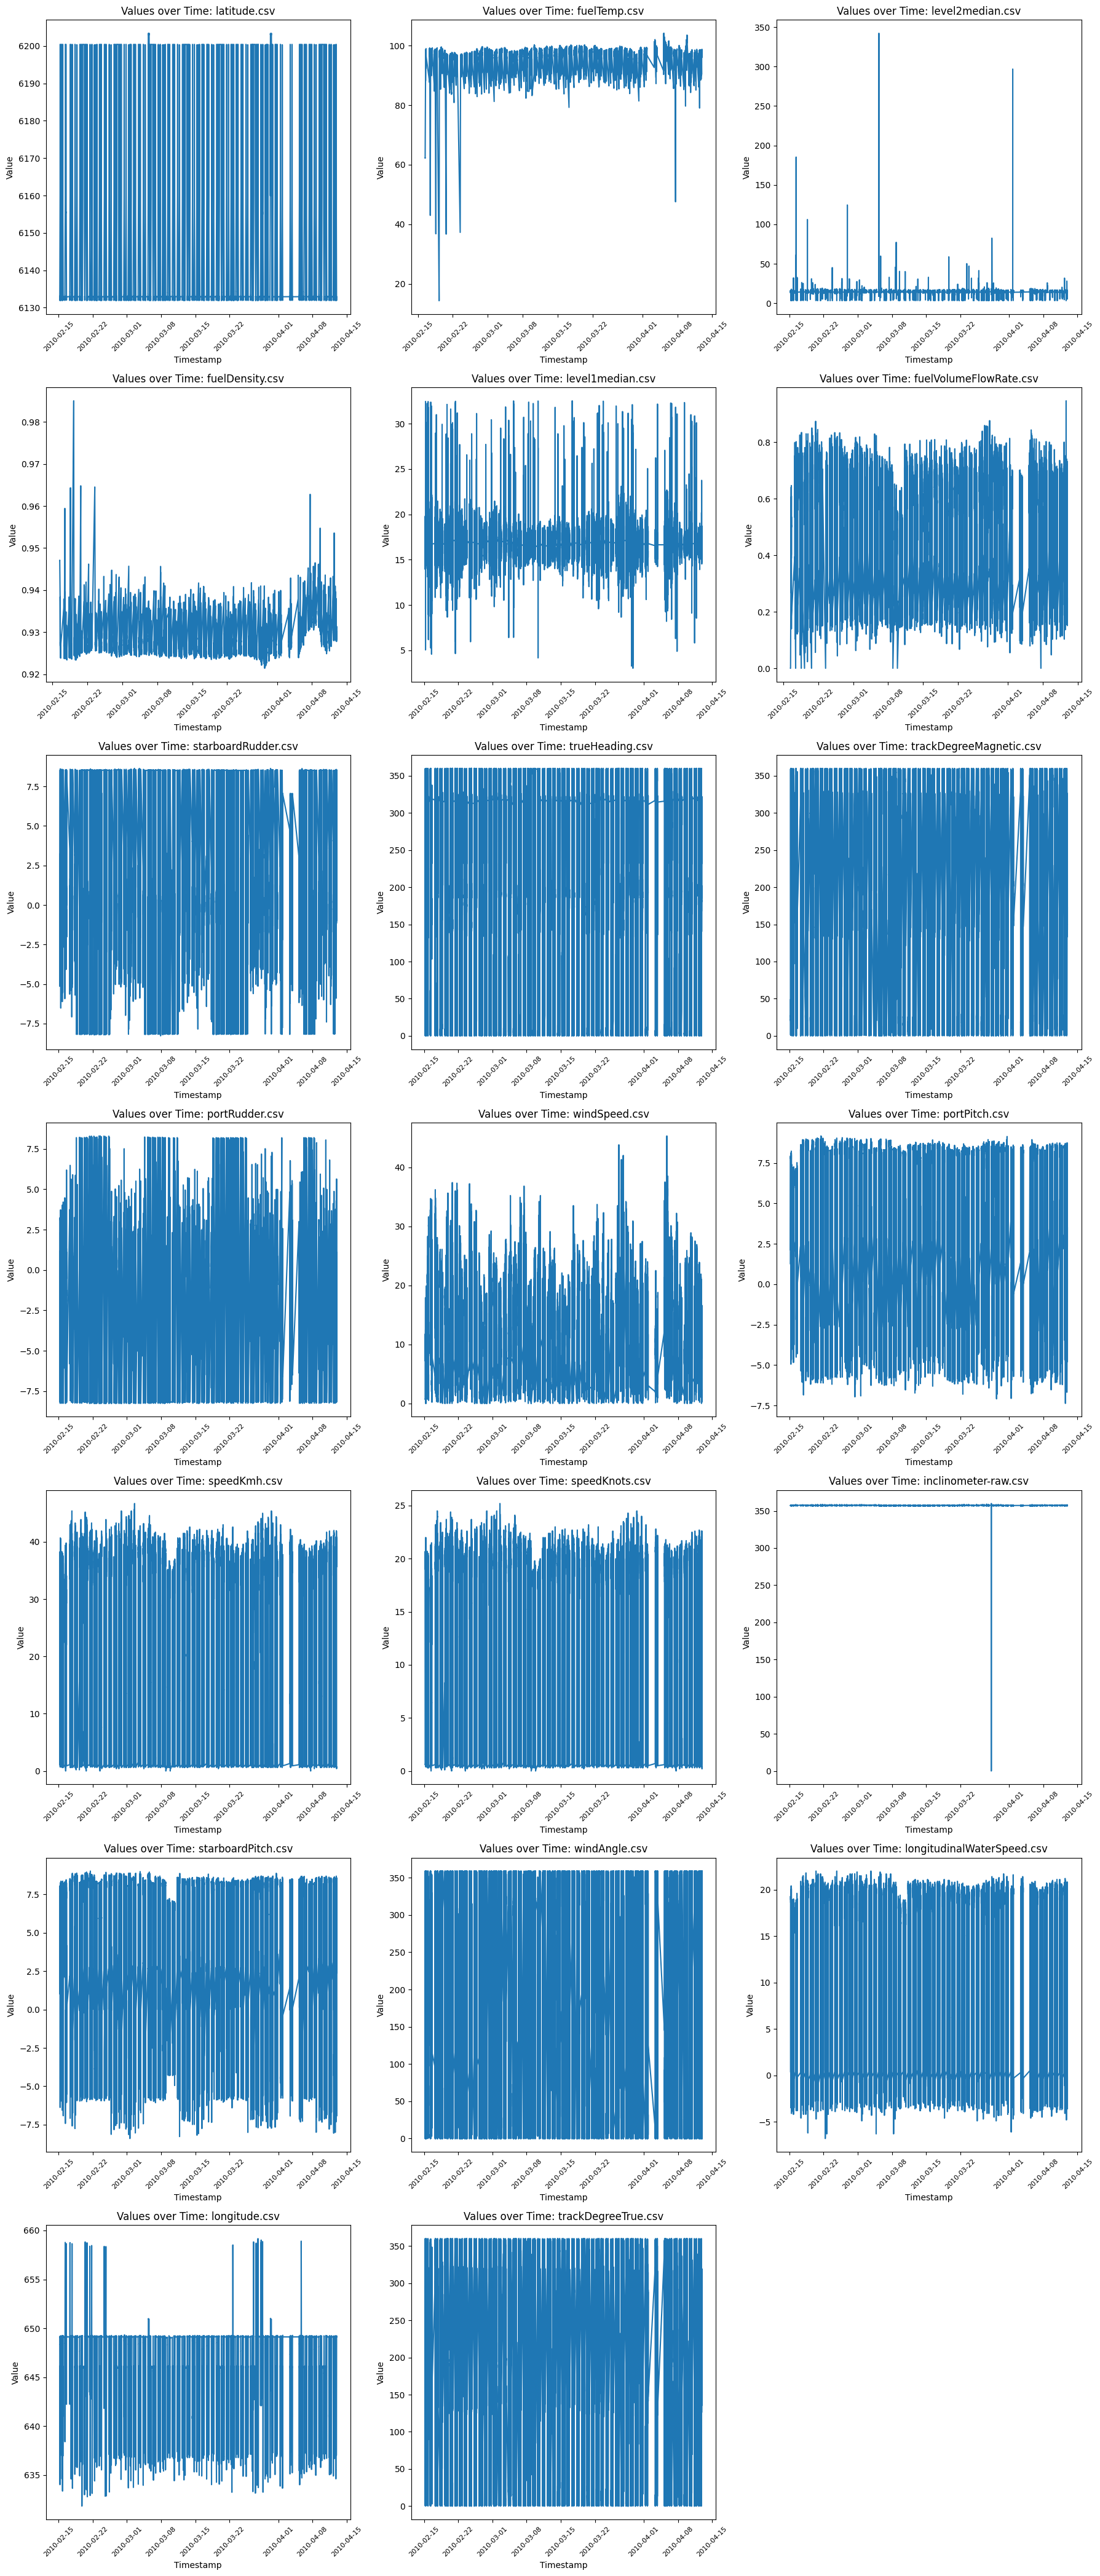

In [6]:
# The folder containing the CSV files
folder_path = './rawdata'

# Create a figure and axes for subplots
fig, axes = plt.subplots(nrows=len(os.listdir(folder_path))//3 + 1, ncols=3, figsize=(18, 6 * (len(os.listdir(folder_path))//3 + 1)))

# Counter for subplots
plot_num = 0

# Iterate over all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        # Construct the full file path
        file_path = os.path.join(folder_path, filename)

        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path, sep=',', header=None, names=['timestamp', 'value'])

        # Convert the timestamp column to datetime
        df['timestamp'] = df['timestamp'].apply(windows_file_time_to_datetime)

        # Remove trailing alphabetic characters from the 'value' column
        df['value'] = df['value'].astype(str).str.rstrip('NW')

        # Convert 'value' back to a numeric type if needed
        df['value'] = pd.to_numeric(df['value'], errors='coerce')

        # Plot in a subplot
        row = plot_num // 3
        col = plot_num % 3

        # Print the head of the DataFrame
        print(f"Preparing data in the file: {filename} for visualization")

        axes[row, col].plot(df['timestamp'], df['value'], label=filename)
        axes[row, col].set_title(f"Values over Time: {filename}")
        axes[row, col].set_xlabel("Timestamp")
        axes[row, col].set_ylabel("Value")
        axes[row, col].tick_params(axis='x', rotation=45, labelsize=8)  # Adjust label size

        plot_num += 1

# Hide any unused subplots
for i in range(plot_num, len(axes.flat)):
    axes.flat[i].set_visible(False)

# prevent labels from overlapping
plt.tight_layout()
plt.show()

## **4. Analyze the distribution of consecutive time gaps in all csv files**

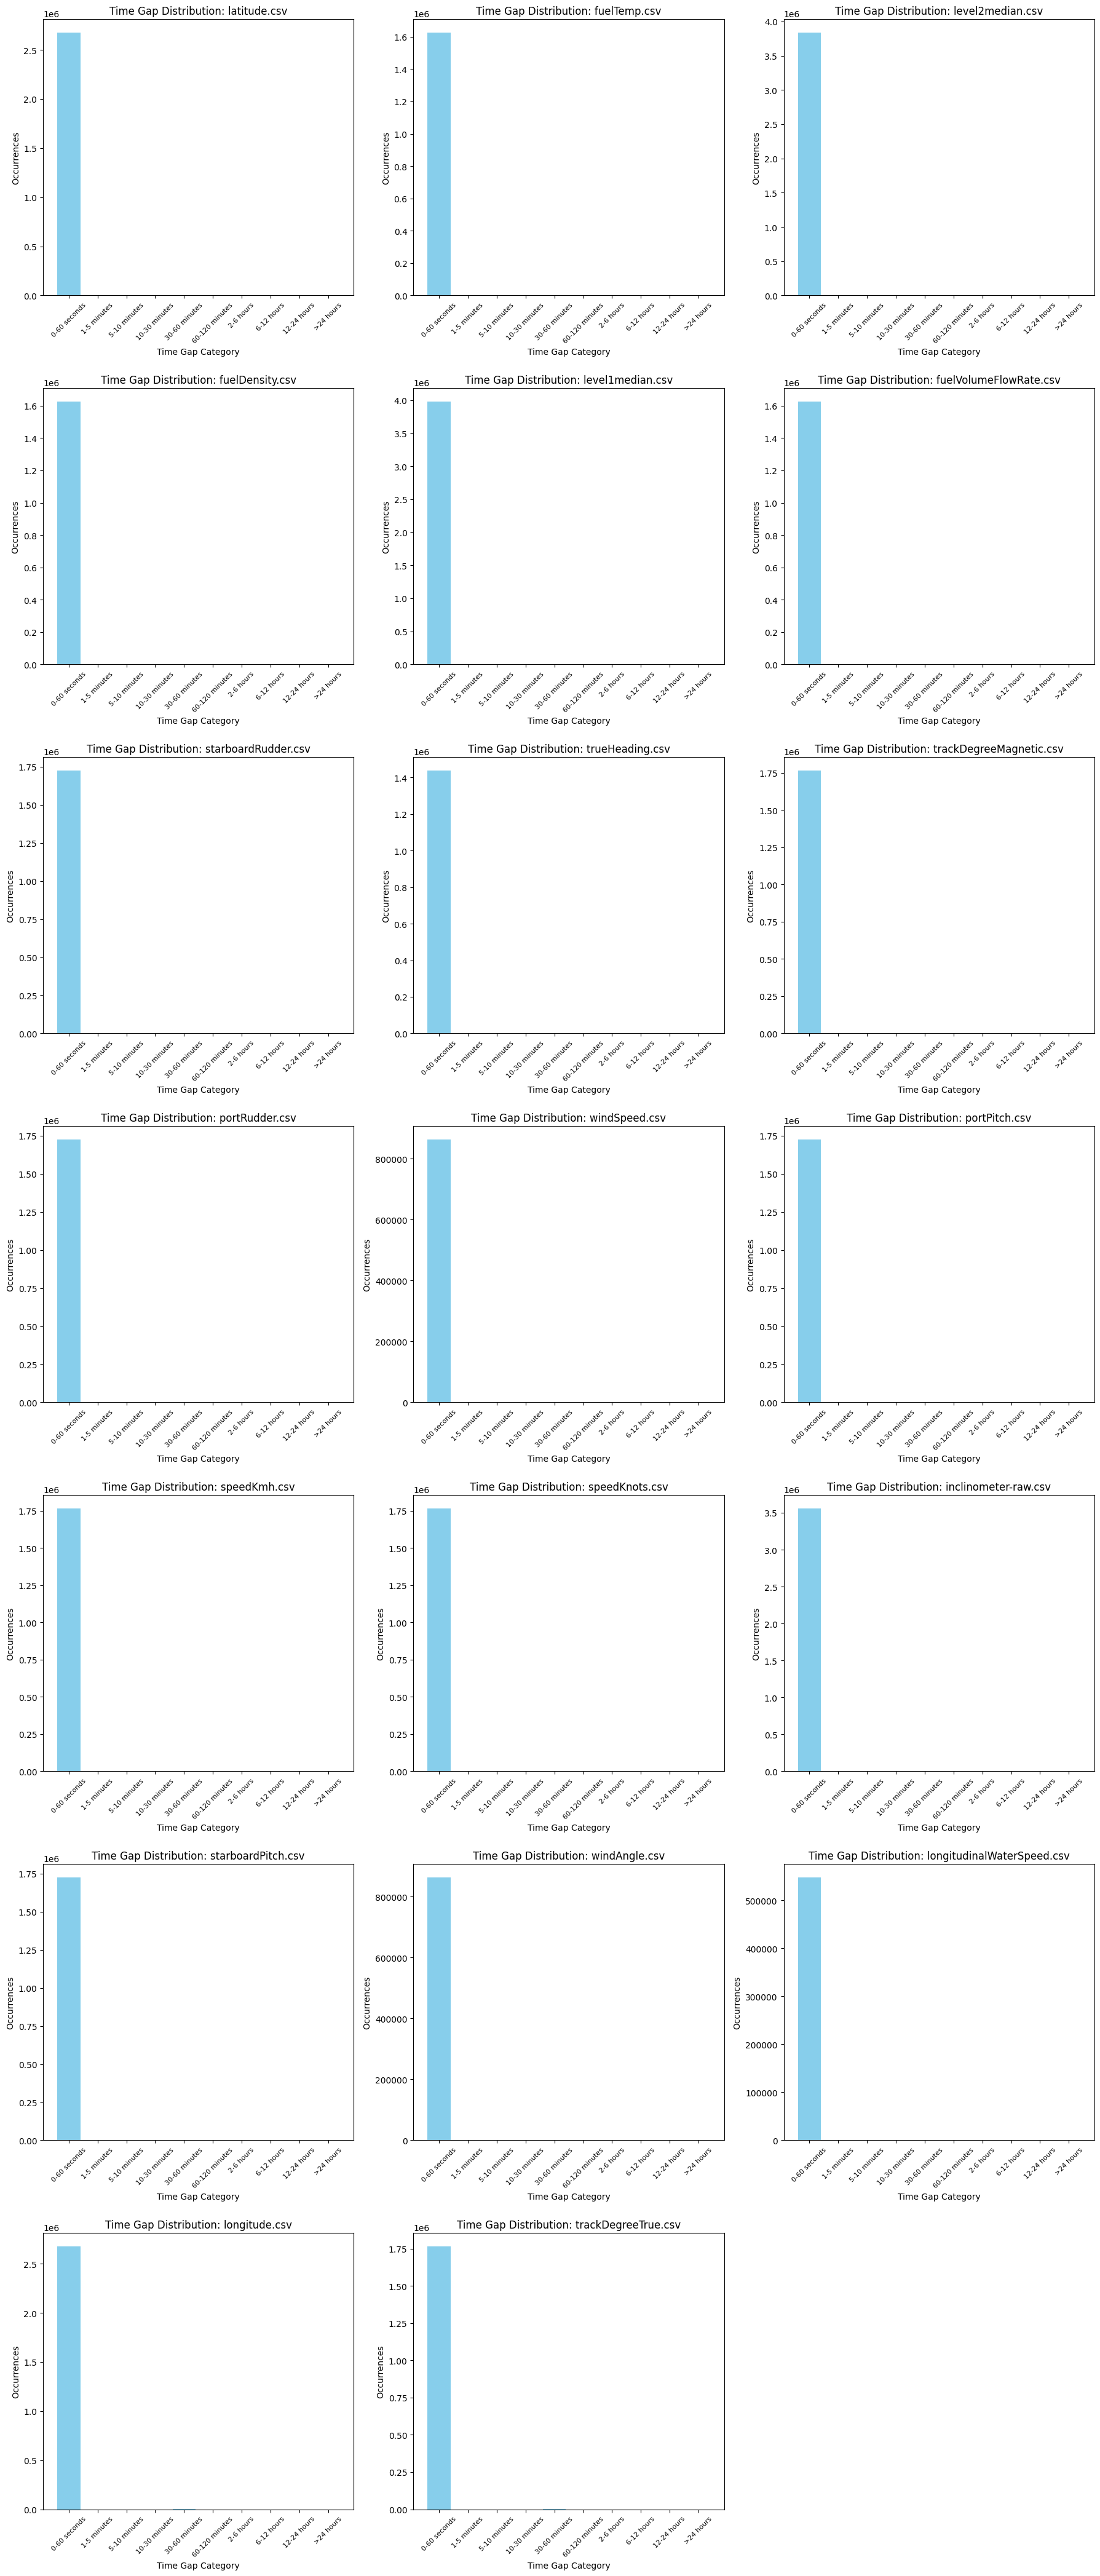

In [7]:

def analyze_time_gaps(df):
    """Analyzes time gaps in a DataFrame and returns counts and labels."""

    time_gaps = {
        (0, 60): "0-60 seconds",
        (60, 300): "1-5 minutes",
        (300, 600): "5-10 minutes",
        (600, 1800): "10-30 minutes",
        (1800, 3600): "30-60 minutes",
        (3600, 7200): "60-120 minutes",
        (7200, 21600): "2-6 hours",
        (21600, 43200): "6-12 hours",
        (43200, 86400): "12-24 hours",
        (86400, float('inf')): ">24 hours"
    }

    gap_counts = []
    labels = []
    for (min_val, max_val), label in time_gaps.items():
        count = len(df[(df['time_diff'] >= min_val) & (df['time_diff'] < max_val)])
        gap_counts.append(count)
        labels.append(label)

    return gap_counts, labels


# Create a figure and axes for subplots
fig, axes = plt.subplots(nrows=len(os.listdir(folder_path))//3 + 1, ncols=3, figsize=(18, 6 * (len(os.listdir(folder_path))//3 + 1)))

# Counter for subplots
plot_num = 0


# Iterate over CSV files
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        # Read and pre-process data (same as your previous code)
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path, sep=',', header=None, names=['timestamp', 'value'])
        df['timestamp'] = df['timestamp'].apply(windows_file_time_to_datetime)
        df['value'] = df['value'].astype(str).str.rstrip('NW')
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        df = df.sort_values(by='timestamp')
        df['time_diff'] = df['timestamp'].diff().dt.total_seconds()

        # Analyze time gaps
        gap_counts, labels = analyze_time_gaps(df)

        # Plot in a subplot
        row = plot_num // 3
        col = plot_num % 3

        axes[row, col].bar(labels, gap_counts, color='skyblue')
        axes[row, col].set_title(f"Time Gap Distribution: {filename}")
        axes[row, col].set_xlabel("Time Gap Category")
        axes[row, col].set_ylabel("Occurrences")
        axes[row, col].tick_params(axis='x', rotation=45, labelsize=8)  # Adjust label size

        plot_num += 1

# Hide any unused subplots
for i in range(plot_num, len(axes.flat)):
    axes.flat[i].set_visible(False)

plt.tight_layout() # prevent labels from overlapping
plt.show()


**Note:**

In every csv file, almost all the timegaps are below 1 minute.

In [8]:
# Analyze the statistical data of consecutive time gaps of one csv file


df = pd.read_csv(f'{folder_path}/starboardPitch.csv', sep=',', header=None, names=['timestamp', 'value'])

# Convert the timestamp column to datetime objects if it's not already
df['timestamp'] = df['timestamp'].apply(windows_file_time_to_datetime)

# Calculate time differences between consecutive timestamps
df['time_diff'] = df['timestamp'].diff().dt.total_seconds()

# Describe the 'time_diff' column
print(df['time_diff'].describe())

count    1.726075e+06
mean     2.837885e+00
std      2.438008e+02
min      1.000511e+00
25%      1.000572e+00
50%      1.000587e+00
75%      1.000717e+00
max      1.248767e+05
Name: time_diff, dtype: float64



**Notes**

*   The median (50th percentile) time difference is approximately 1 second, meaning that half of the recorded timestamps arrive within 1-second intervals.

*  Additionally, the 25th and 75th percentiles are also around 1 second, confirming that the majority of the data points have minimal time gaps.

*   However, the maximum gap observed is approximately 34.7 hours (124,876 seconds), indicating the presence of missing timestamps over extended periods.
*   The high standard deviation (243.8 seconds ≈ 4 minutes) further suggests variability in time differences, primarily due to these occasional large gaps.


*   Given that 75% of the data points have time gaps of about 1 second, choosing a **1-minute resampling window strikes a balance between reducing redundancy and preserving meaningful trends**.








## **5. Resample the data and merge into a dataframe**

In [9]:
# Initialize an empty list to store individual DataFrames
dfs = []
start_timestamps = []
end_timestamps = []

# Iterate through all CSV files in the directory
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        print(f'processing file: {filename}')

        file_path = os.path.join(folder_path, filename)

        # Read CSV file (assuming two columns: timestamp, value)
        df = pd.read_csv(file_path, sep=",", header=None, names=["timestamp", "value"])

        # Convert Windows File Time to datetime
        df["timestamp"] = df["timestamp"].apply(windows_file_time_to_datetime)

        # Remove trailing alphabetic characters from the 'value' column
        df['value'] = df['value'].apply(convert_to_float)

        # Sort timestamps to ensure correct gap calculation
        df.sort_values("timestamp", inplace=True)

        # Store start and end timestamps for range selection
        start_timestamps.append(df["timestamp"].iloc[0])
        end_timestamps.append(df["timestamp"].iloc[-1])

        # Compute time gaps between consecutive timestamps
        df["time_diff"] = df["timestamp"].diff().dt.total_seconds()

        # Initialize list to store processed data
        processed_data = []
        start_idx = 0

        # Iterates through the dataset row by row (excluding the first row)
        for i in range(1, len(df)):
            # If if the time gap (time_diff) between two consecutive timestamps is greater than 60 seconds,
            if df.loc[i, "time_diff"] > 60:
                # collects the segment of data before the gap (start_idx to i)
                segment = df.iloc[start_idx:i].set_index("timestamp")
                # resamples only that segment (where the gaps are less than 1 minute)
                resampled_segment = segment.resample("1min").mean()
                # stores the resampled segment
                processed_data.append(resampled_segment)
                # updates start_idx = i so that the next segment starts after the gap
                start_idx = i

        # Add the last segment
        segment = df.iloc[start_idx:].set_index("timestamp")
        resampled_segment = segment.resample("1min").mean()
        processed_data.append(resampled_segment)

        # Concatenate all segments
        df_resampled = pd.concat(processed_data)

        # Rename the 'value' column to include the filename
        column_name = filename.replace(".csv", "")
        df_resampled.rename(columns={"value": column_name}, inplace=True)

        # drop time_diff
        df_resampled.drop(columns=["time_diff"], inplace=True)

        # Append to list
        dfs.append(df_resampled)

# Find the common time range
latest_start = max(start_timestamps)  # Latest start timestamp
earliest_end = min(end_timestamps)  # Earliest end timestamp

# Merge all DataFrames on timestamp
df_merged = pd.concat(dfs, axis=1)

# Reset index to make timestamp a column
df_merged.reset_index(inplace=True)

# Filter data within the common time range
df_filtered = df_merged[(df_merged["timestamp"] >= latest_start) & (df_merged["timestamp"] <= earliest_end)]

# Display result
df_filtered.head()

processing file: latitude.csv
processing file: fuelTemp.csv
processing file: level2median.csv
processing file: fuelDensity.csv
processing file: level1median.csv
processing file: fuelVolumeFlowRate.csv
processing file: starboardRudder.csv
processing file: trueHeading.csv
processing file: trackDegreeMagnetic.csv
processing file: portRudder.csv
processing file: windSpeed.csv
processing file: portPitch.csv
processing file: speedKmh.csv
processing file: speedKnots.csv
processing file: inclinometer-raw.csv
processing file: starboardPitch.csv
processing file: windAngle.csv
processing file: longitudinalWaterSpeed.csv
processing file: longitude.csv
processing file: trackDegreeTrue.csv


,timestamp,latitude,fuelTemp,level2median,fuelDensity,level1median,fuelVolumeFlowRate,starboardRudder,trueHeading,trackDegreeMagnetic,...,windSpeed,portPitch,speedKmh,speedKnots,inclinometer-raw,starboardPitch,windAngle,longitudinalWaterSpeed,longitude,trackDegreeTrue
883,2010-02-16 12:48:00,6200.423931,89.819019,14.323443,0.934648,16.796534,0.316942,4.345348,174.034872,226.312245,...,15.366667,0.611261,2.496000,1.342000,357.305729,1.760978,263.916667,0.520000,645.951672,219.112245
884,2010-02-16 12:49:00,6200.375122,92.439702,14.187675,0.931630,16.858050,0.468066,-2.077650,189.594200,201.286667,...,15.793333,4.090200,9.956667,5.376667,357.874919,5.597967,233.333333,4.105263,645.981611,194.086667
885,2010-02-16 12:50:00,6200.232325,92.487234,14.209960,0.932165,17.370415,0.388901,0.936050,193.884200,207.508065,...,11.910000,4.992900,20.472581,11.058065,357.515610,6.098767,230.533333,10.357895,646.093679,200.308065
886,2010-02-16 12:51:00,6189.053319,89.188604,13.774171,0.936145,17.640626,0.492076,0.856900,162.055200,165.204918,...,19.843333,5.612250,23.729508,12.814754,357.478871,7.107300,282.966667,12.521053,646.072665,158.004918
887,2010-02-16 12:52:00,6159.878870,90.341803,13.958831,0.932726,16.940402,0.476808,-0.251000,138.184200,134.545161,...,23.986667,6.114933,27.964516,15.098387,357.230000,7.423000,309.800000,14.694737,645.730561,127.345161


## **6. Handle missing values**

In [11]:
# Forward-fill missing values
df_filtered = df_filtered.copy()
df_filtered.ffill(inplace=True)

## **7. Feature Engineering**

In [12]:
# Create new features
df_filtered['headingStability'] = df_filtered['trueHeading'] - df_filtered['trackDegreeTrue']
df_filtered['rudderDifference'] = df_filtered['portRudder'] - df_filtered['starboardRudder']

In [13]:
# Create the Target column (Energy Consumption)

df_filtered['energy_consumption'] = df_filtered['fuelDensity'] * df_filtered['fuelVolumeFlowRate'] * 60
df_filtered = df_filtered.drop(['fuelDensity', 'fuelVolumeFlowRate'], axis=1)
df_filtered.head()

# Display the updated DataFrame
df_filtered.head()

,timestamp,latitude,fuelTemp,level2median,level1median,starboardRudder,trueHeading,trackDegreeMagnetic,portRudder,windSpeed,...,speedKnots,inclinometer-raw,starboardPitch,windAngle,longitudinalWaterSpeed,longitude,trackDegreeTrue,headingStability,rudderDifference,energy_consumption
883,2010-02-16 12:48:00,6200.423931,89.819019,14.323443,16.796534,4.345348,174.034872,226.312245,-1.256478,15.366667,...,1.342000,357.305729,1.760978,263.916667,0.520000,645.951672,219.112245,-45.077373,-5.601826,17.773777
884,2010-02-16 12:49:00,6200.375122,92.439702,14.187675,16.858050,-2.077650,189.594200,201.286667,-2.117500,15.793333,...,5.376667,357.874919,5.597967,233.333333,4.105263,645.981611,194.086667,-4.492467,-0.039850,26.163876
885,2010-02-16 12:50:00,6200.232325,92.487234,14.209960,17.370415,0.936050,193.884200,207.508065,0.972800,11.910000,...,11.058065,357.515610,6.098767,230.533333,10.357895,646.093679,200.308065,-6.423865,0.036750,21.751191
886,2010-02-16 12:51:00,6189.053319,89.188604,13.774171,17.640626,0.856900,162.055200,165.204918,0.898967,19.843333,...,12.814754,357.478871,7.107300,282.966667,12.521053,646.072665,158.004918,4.050282,0.042067,27.639303
887,2010-02-16 12:52:00,6159.878870,90.341803,13.958831,16.940402,-0.251000,138.184200,134.545161,-0.232550,23.986667,...,15.098387,357.230000,7.423000,309.800000,14.694737,645.730561,127.345161,10.839039,0.018450,26.683867


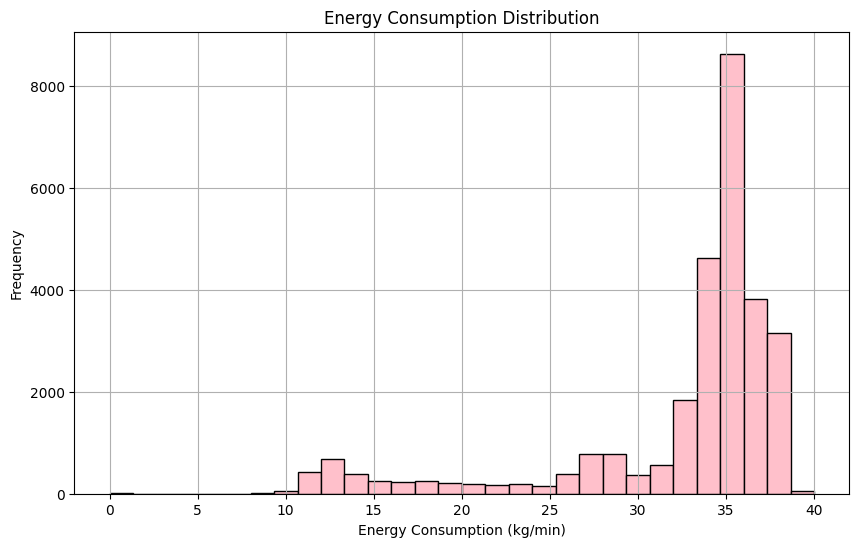

In [14]:
# Plotting the energy consumption histogram
plt.figure(figsize=(10, 6))
plt.hist(df_filtered['energy_consumption'], bins=30, color='pink', edgecolor='black')
plt.title('Energy Consumption Distribution')
plt.xlabel('Energy Consumption (kg/min)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

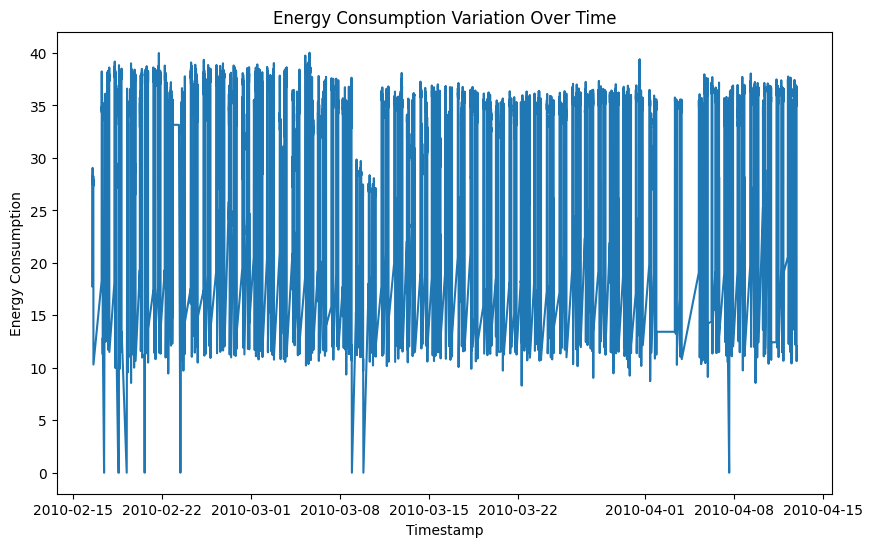

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(df_filtered['timestamp'], df_filtered['energy_consumption'])
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.title('Energy Consumption Variation Over Time')
plt.show()


## **8. Feature Scaling and Correlation Analysis**

In [16]:
# Select numerical features for scaling (exclude timestamp and any non-numeric columns)
numerical_cols = df_filtered.select_dtypes(include=['number']).columns
numerical_cols = numerical_cols.drop('energy_consumption')

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical features
df_filtered[numerical_cols] = scaler.fit_transform(df_filtered[numerical_cols])

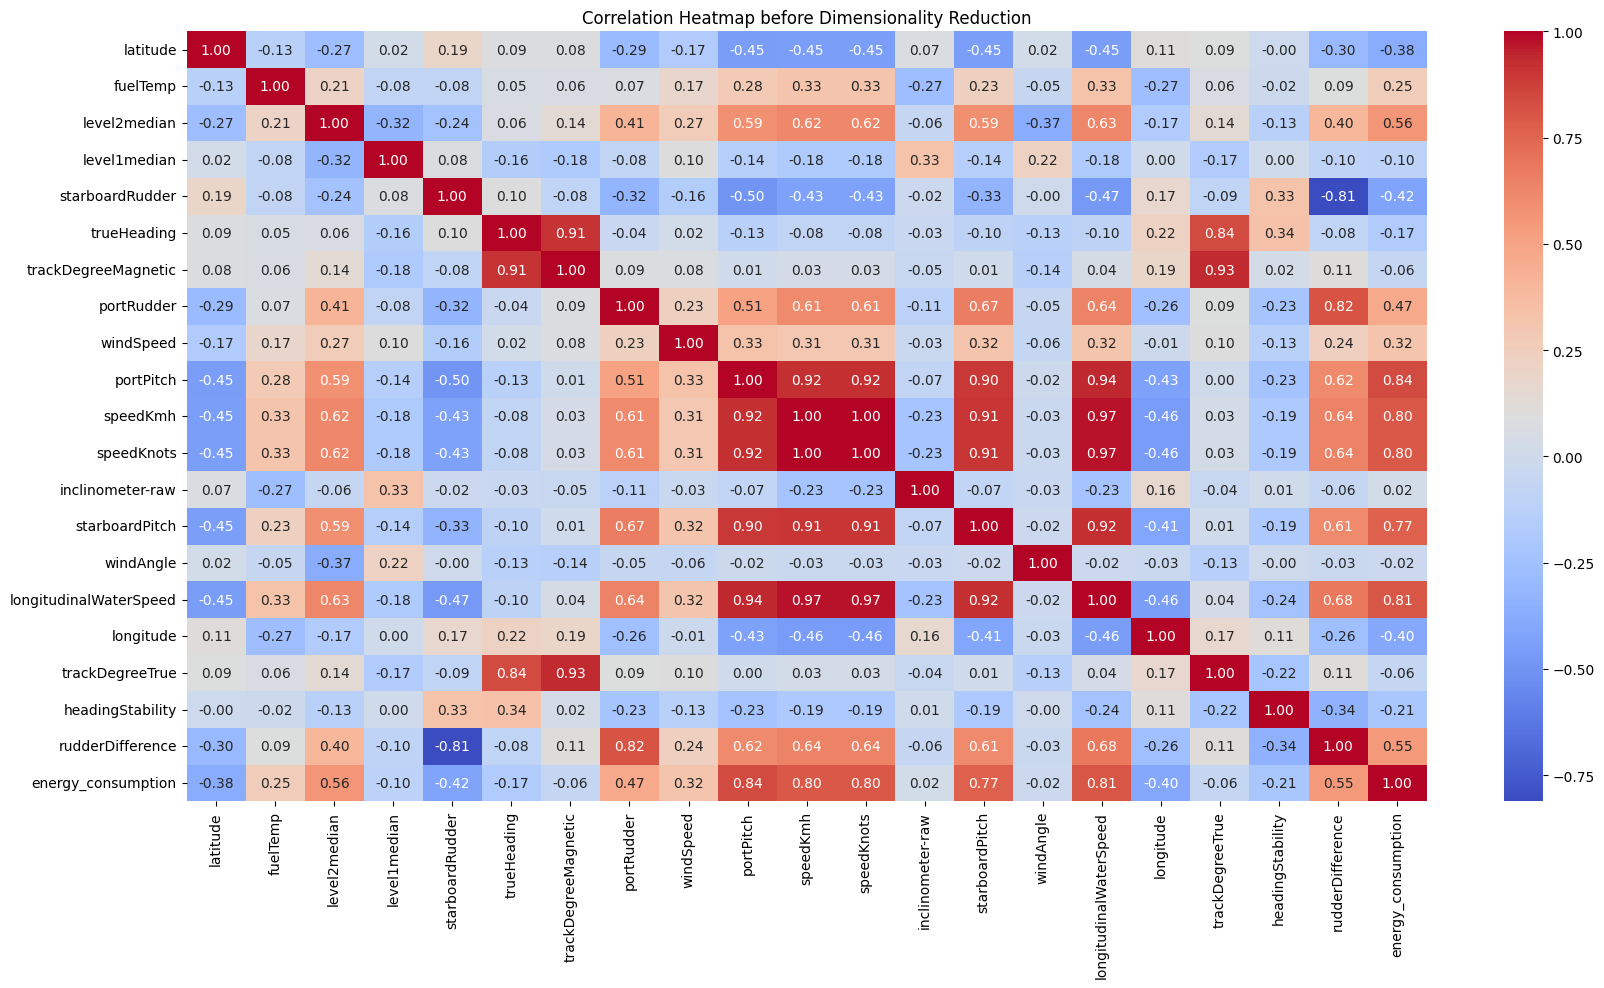

In [17]:
# Drop the timestamp column
df_filtered = df_filtered.drop(columns=['timestamp'])

# Calculate the correlation matrix
correlation_matrix = df_filtered.corr()

# Create the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap before Dimensionality Reduction')
plt.show()


## **9. Dimensioanlity Reduction**

In [18]:
# Drop columns having low correlation coefficients and being used directly for the target variable calculation
df_filtered = df_filtered.drop(['starboardRudder', 'portRudder', 'trackDegreeTrue', 'trackDegreeMagnetic', 'speedKmh', 'windAngle', 'trueHeading',
    'level1median', 'speedKnots', 'inclinometer-raw', 'trackDegreeMagnetic', 'longitudinalWaterSpeed', 'starboardPitch'], axis=1)

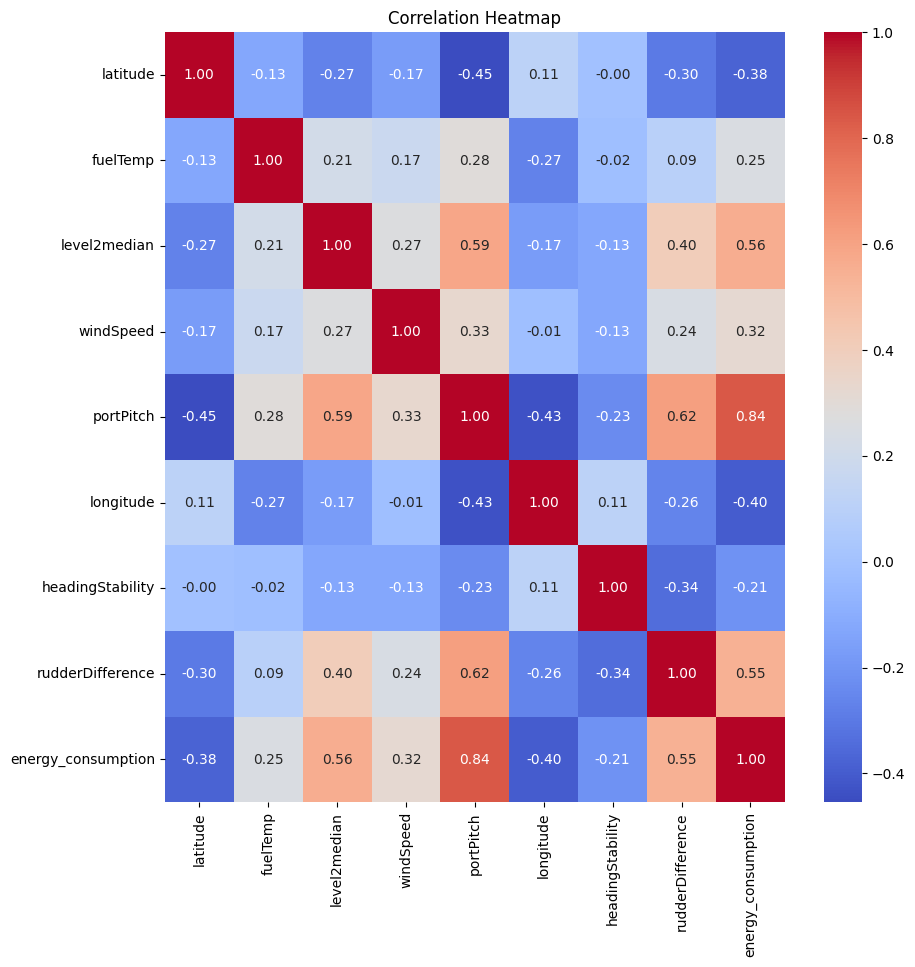

In [19]:
# Calculate the correlation matrix after the dimensioanlity reduction
correlation_matrix = df_filtered.corr()

# Create the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

## **10. Split the dataset**

In [20]:
# Define features (X) and target variable (y)
X = df_filtered.drop(columns=['energy_consumption'])  # Exclude 'energy_consumption' and 'timestamp'
y = df_filtered['energy_consumption']

# Split data into train, eval, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 70% train, 30% temp

# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42) # 5 fold cross validation


## **11. Train, Evaluate and Test Model 1: Random Forest Regressor**

Random Forest R-squared (cross-validation): 0.9615706241618908
Random Forest R-squared (test): 0.9620086488324473


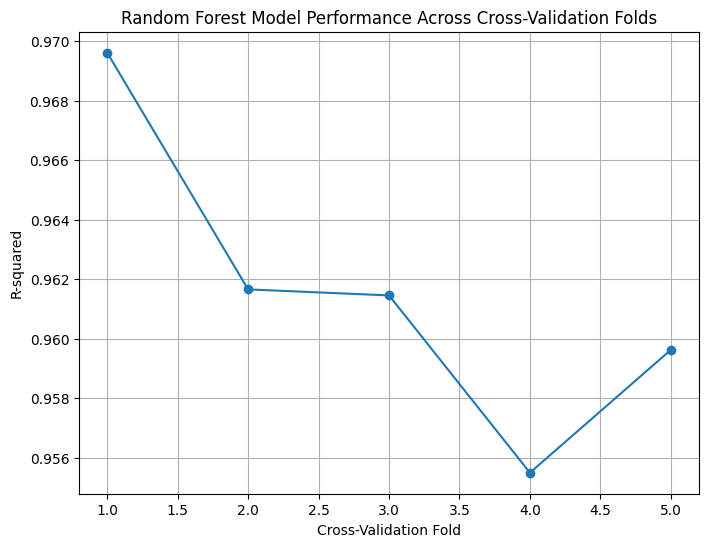

In [21]:
# Initialize the Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=42)

# Evaluate Random Forest using cross-validation
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring='r2')
print("Random Forest R-squared (cross-validation):", rf_scores.mean())

# Train and evaluate Random Forest on the training set
rf_model.fit(X_train, y_train)

# Evaluate Random Forest on the test set
rf_pred_test = rf_model.predict(X_test)
rf_r2_test = r2_score(y_test, rf_pred_test)
print("Random Forest R-squared (test):", rf_r2_test)

#Plot for random forest
# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(rf_scores) + 1), rf_scores, marker='o', linestyle='-')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('R-squared')
plt.title('Random Forest Model Performance Across Cross-Validation Folds')
plt.grid(True)
plt.show()

## **12. Train, Evaluate and Test Model 1: KNN Regressor**

KNN R-squared (cross-validation): 0.9157536046912028
KNN R-squared (test): 0.924581361015174


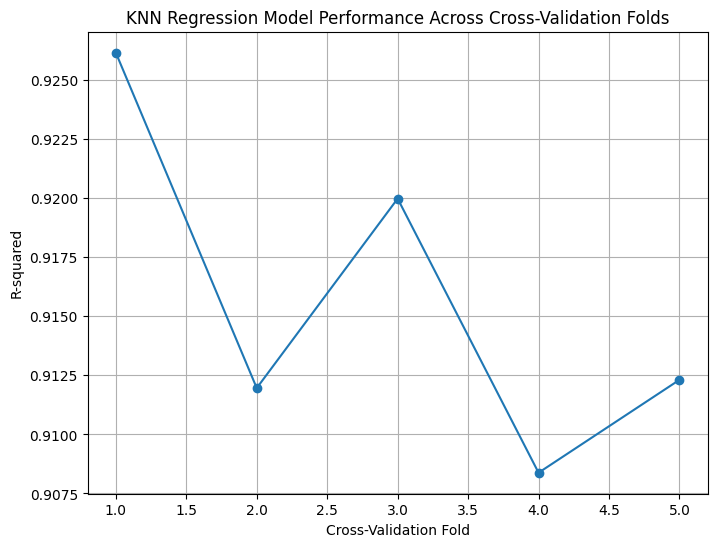

In [22]:
# Initialize the KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)  # You can adjust the number of neighbors

# Evaluate KNN using cross-validation
knn_scores = cross_val_score(knn_model, X_train, y_train, cv=kf, scoring='r2')
print("KNN R-squared (cross-validation):", knn_scores.mean())

# Train the KNN model
knn_model.fit(X_train, y_train)

# Make predictions on the test set
knn_pred_test = knn_model.predict(X_test)

# Evaluate the KNN model on the test set
knn_r2_test = r2_score(y_test, knn_pred_test)
print("KNN R-squared (test):", knn_r2_test)

#Plot for random forest
# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(knn_scores) + 1), knn_scores, marker='o', linestyle='-')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('R-squared')
plt.title('KNN Regression Model Performance Across Cross-Validation Folds')
plt.grid(True)
plt.show()

## **13. Hyperparameter Optimization for Random Forest Regressor**

In [23]:
# Define the parameter grid for RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20]
}

# Create a RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=kf, scoring='r2', n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)


# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Train a new model with the best hyperparameters
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Predict on the test set using the best model
best_rf_pred_test = best_rf_model.predict(X_test)

# Calculate the R-squared score for the best model
best_rf_r2_test = r2_score(y_test, best_rf_pred_test)
print("Best Random Forest R-squared (test):", best_rf_r2_test)


Best hyperparameters: {'max_depth': None, 'n_estimators': 100}
Best Random Forest R-squared (test): 0.9620086488324473


## **14. Hyperparameter Optimizer for KNN Regressor**

In [24]:
# Define the parameter grid for KNeighborsRegressor
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

# Create a KNeighborsRegressor model
knn_model = KNeighborsRegressor()

# Create GridSearchCV object
grid_search_knn = GridSearchCV(estimator=knn_model, param_grid=param_grid_knn, cv=kf, scoring='r2', n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search_knn.fit(X_train, y_train)

# Get the best hyperparameters
best_params_knn = grid_search_knn.best_params_
print("Best hyperparameters for KNN:", best_params_knn)

# Train a new KNN model with the best hyperparameters
best_knn_model = KNeighborsRegressor(**best_params_knn)
best_knn_model.fit(X_train, y_train)

# Predict on the test set using the best KNN model
best_knn_pred_test = best_knn_model.predict(X_test)

# Calculate the R-squared score for the best KNN model
best_knn_r2_test = r2_score(y_test, best_knn_pred_test)
print("Best KNN R-squared (test):", best_knn_r2_test)


Best hyperparameters for KNN: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Best KNN R-squared (test): 0.9363634798168263
